# FCN-32 Analyses
Authors: Sophie Zhao, Tolya Evdokimov

In this notebook, we generate the visualizations and conduct analyses for the FCN-32 model. These include confusion matrix, f-1 scores, precision, and recall for each class. Additionally, we generate several predicted images for the examples in the report.

In [1]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sys.path.append('../src/')

from models.fcn32 import fcn_32
from data.utils import preprocess_dataset

# Declare class-to-color mappings
CLASS_TO_COLOR = {
    0: (17, 141, 215),
    1: (225, 227, 155), 
    2: (127, 173, 123),
    3: (185, 122, 87),
    4: (230, 200, 181),
    5: (150, 150, 150),
    6: (193, 190, 175)
}

## Prepare Model and Data

First, load in the model and its best weights

In [2]:
fcn32 = fcn_32(7, 128, 128, 3)
fcn32.load_weights('../experiments/fcn32/weights/fcn32_01-1.72.h5')

Load the test dataset with 500 examples and preprocess the data

In [3]:
raw_test = tf.data.TFRecordDataset("../dataset/test.tfrecords")
test = preprocess_dataset(raw_test, sum(1 for _ in raw_test))
test = test.unbatch().batch(500)

Run the data through the model to make inferences

In [4]:
fcn32_pred = fcn32.predict(test)

1/1 [==============================] - 6s 6s/step


## 1. Confusion Matrix
For the matrix, we will compare the true labels and the predicted labels, then flatten the dataset and use <code>tf.math.confusion_matrix()</code> to calculate the final matrix

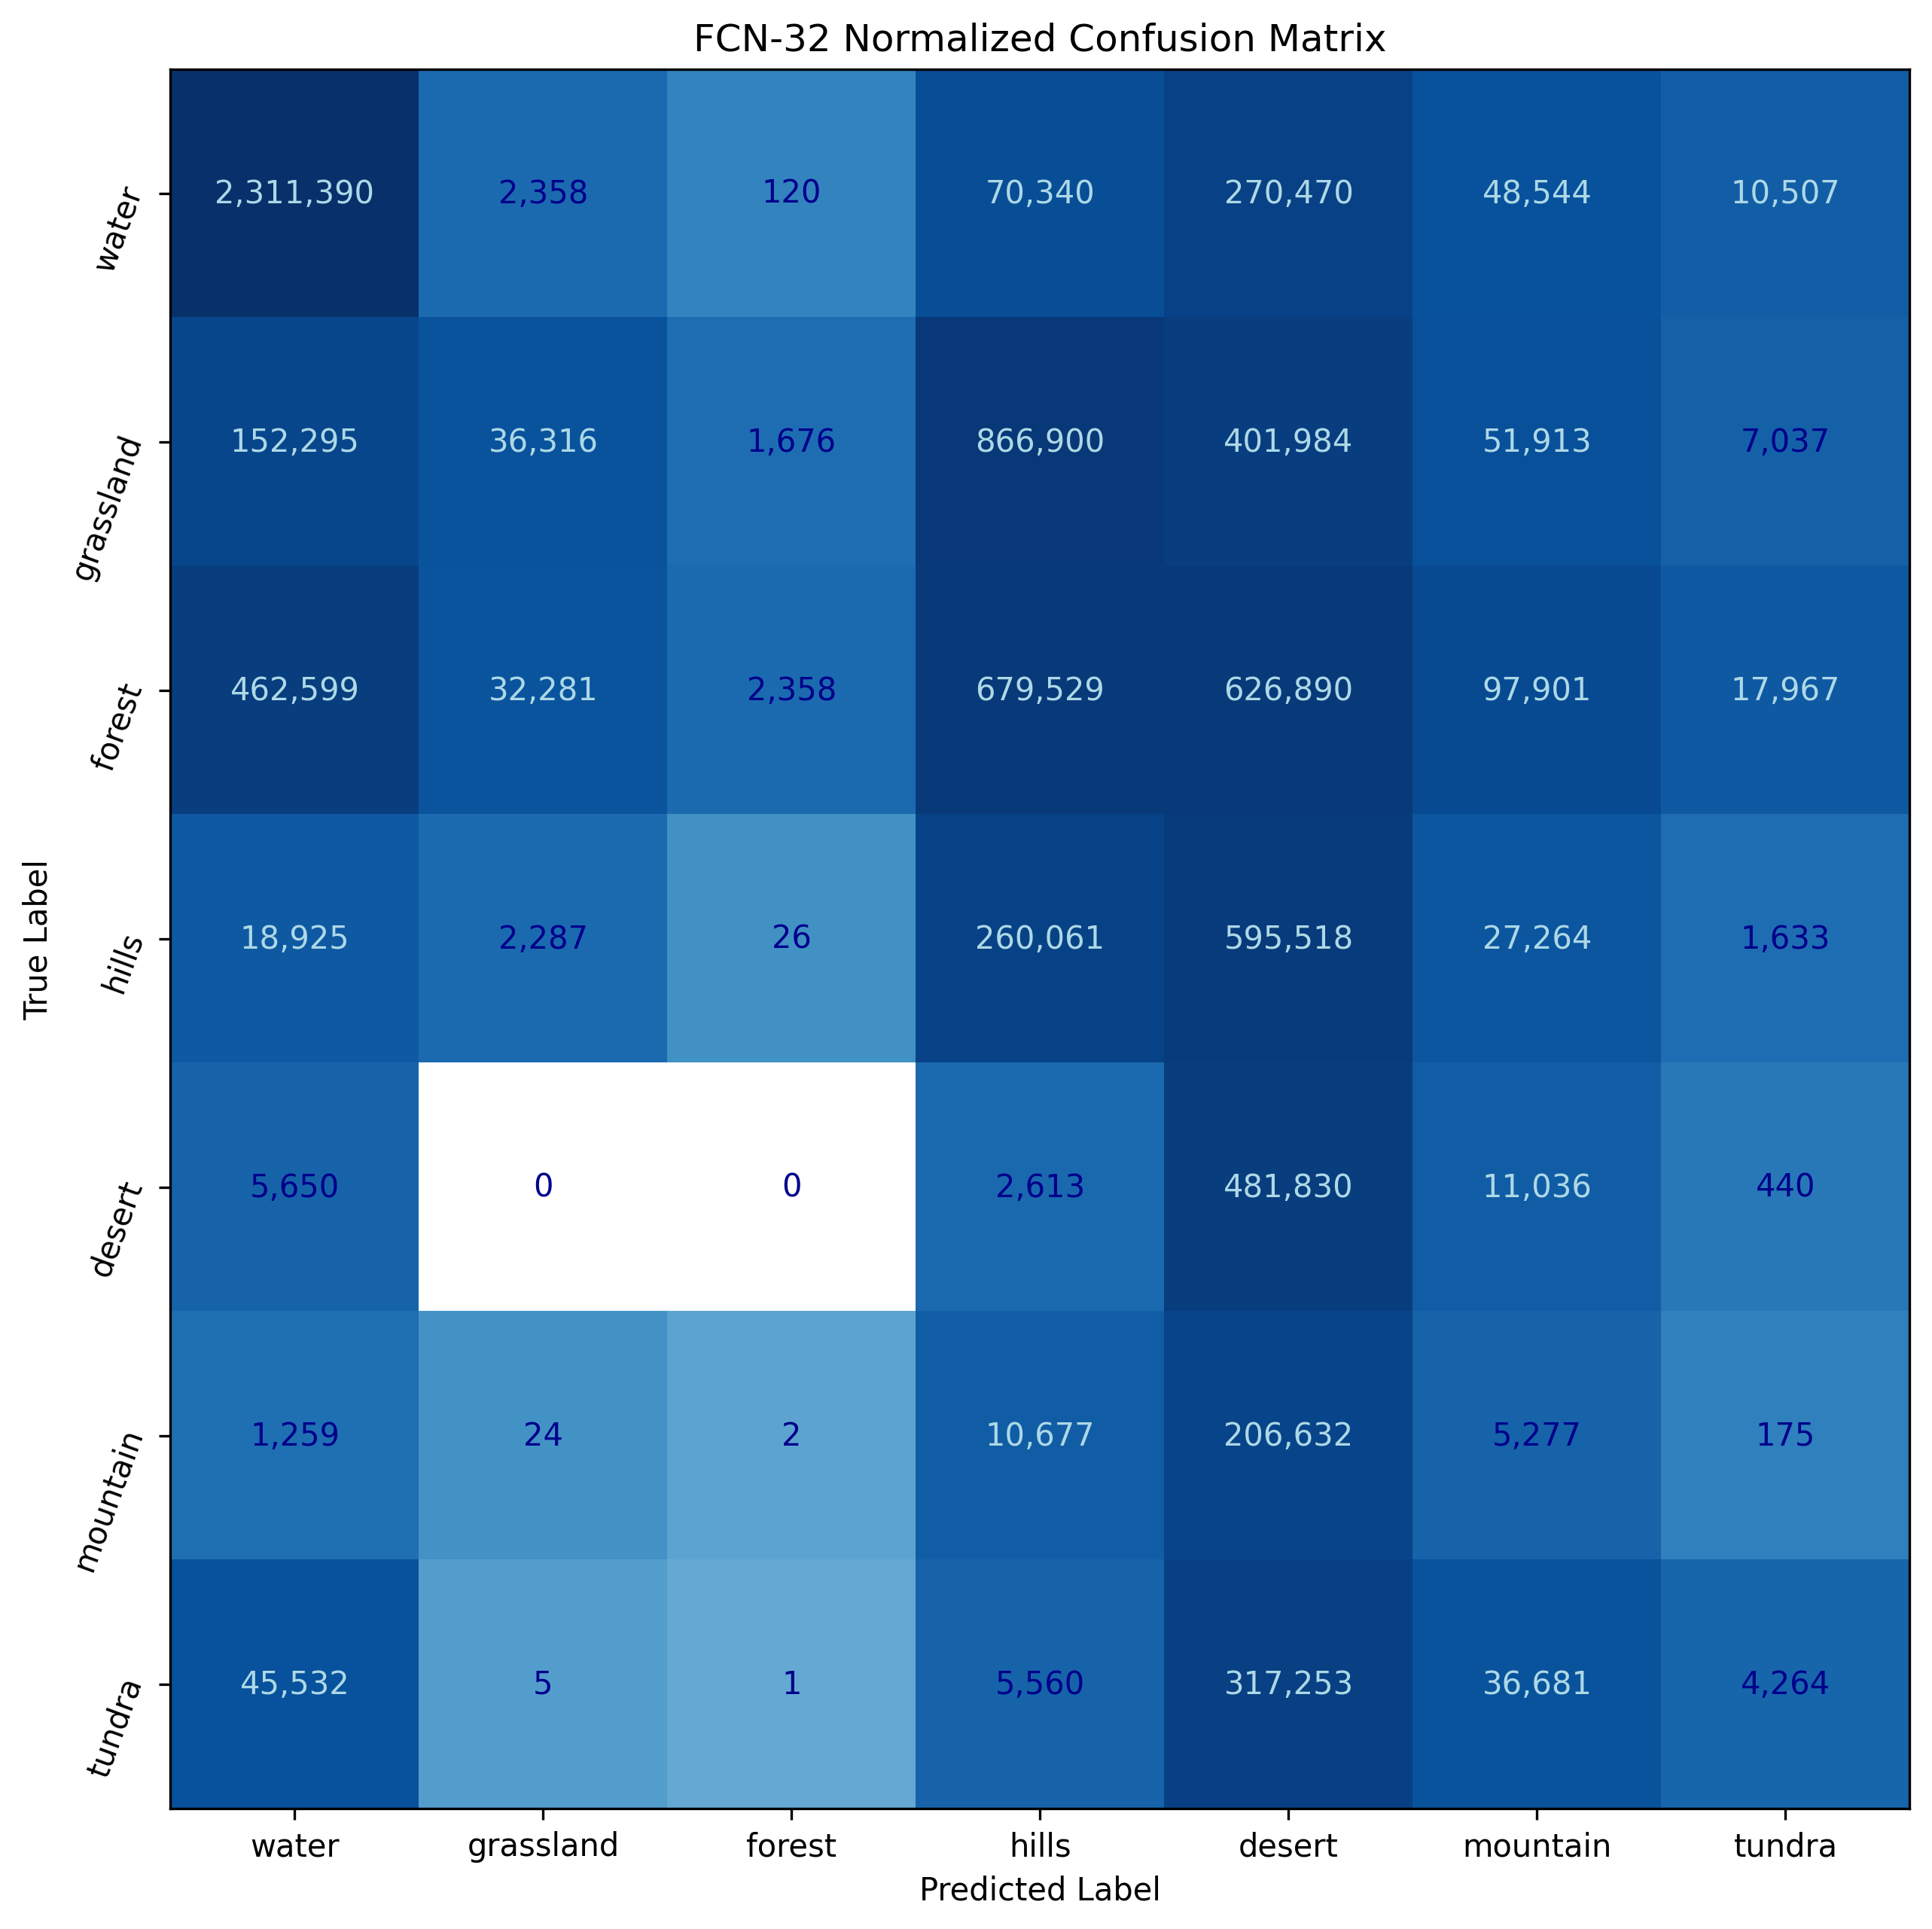

In [12]:

plt.figure(figsize=(10,10),dpi=300)
for example in test.take(1):
    # Get the true and predicted masks
    y_true = example[1]['conv2d_18']
    x = example[0]['input_1']

    y_true_flat = tf.reshape(y_true, (-1, 7))
    y_true_flat = tf.argmax(y_true_flat, axis=-1)
    
    y_pred_flat = tf.reshape(fcn32_pred, (-1, 7))
    y_pred_flat = tf.argmax(y_pred_flat, axis=-1)

    conf_matrix = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=7)
    conf_matrix = np.array(conf_matrix)

    # Plot the confusion matrix heatmap
    plt.imshow(conf_matrix, cmap="Blues", norm=LogNorm(vmin=conf_matrix.min(), vmax=conf_matrix.max()))

# Add axis labels
plt.title('FCN-32 Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

class_labels = ['water', 'grassland', 'forest', 'hills', 'desert', 'mountain', 'tundra']
plt.xticks(range(7), class_labels)
plt.yticks(range(7), class_labels, rotation=70)

# Add annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f'{conf_matrix[i, j]:,}', ha='center', va='center', color="lightblue" if conf_matrix[i, j] > 10000 else "darkblue")


plt.show()

## 2. Precision, Recall, and F1 Score
For the score calculation, we will use the default Keras implementations from <code>tf.keras.metrics</code>

In [7]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1 = tf.keras.metrics.F1Score()

# Reshape the true and predicted masks to have shape (500, 7)
y_true = tf.reshape(y_true, (-1, 7))
y_pred = tf.reshape(fcn32_pred, (-1, 7))

y_true_flat = tf.cast(y_true_flat, dtype=tf.float32)
y_pred_flat = tf.cast(y_pred_flat, dtype=tf.float32)

precision.update_state(y_true_flat, y_pred_flat)
recall.update_state(y_true_flat, y_pred_flat)
f1.update_state(y_true, y_pred)

print(f'Overall Precision: {precision.result().numpy()}')
print(f'Overall Recall: {recall.result().numpy()}')
print(f'F1 Score for each class: {f1.result().numpy()}')

# calculate precision, recall, and f1 by class
for i in range(7):
    precision.reset_states()
    recall.reset_states()

    y_true_flat_class = tf.cast(tf.equal(y_true_flat, i), dtype=tf.float32)
    y_pred_flat_class = tf.cast(tf.equal(y_pred_flat, i), dtype=tf.float32)

    precision.update_state(y_true_flat_class, y_pred_flat_class)
    recall.update_state(y_true_flat_class, y_pred_flat_class)

    print(f'Class {i} Precision: {precision.result().numpy()}')
    print(f'Class {i} Recall: {recall.result().numpy()} \n')

Overall Precision: 0.922542929649353
Overall Recall: 0.8747305274009705
F1 Score for each class: [0.8093982  0.04564054 0.00245152 0.18566543 0.28325063 0.02099617
 0.01889572]
Class 0 Precision: 0.7710673213005066
Class 0 Recall: 0.8517394065856934 

Class 1 Precision: 0.49563947319984436
Class 1 Recall: 0.023921675980091095 

Class 2 Precision: 0.5637102723121643
Class 2 Recall: 0.0012284289114177227 

Class 3 Precision: 0.13718612492084503
Class 3 Recall: 0.28713369369506836 

Class 4 Precision: 0.16611522436141968
Class 4 Recall: 0.9606454968452454 

Class 5 Precision: 0.018940046429634094
Class 5 Recall: 0.02355319820344448 

Class 6 Precision: 0.10146824270486832
Class 6 Recall: 0.010417887941002846 



## 3. Get Example Predicted Images
We will get a few results from our inference for the report visualization

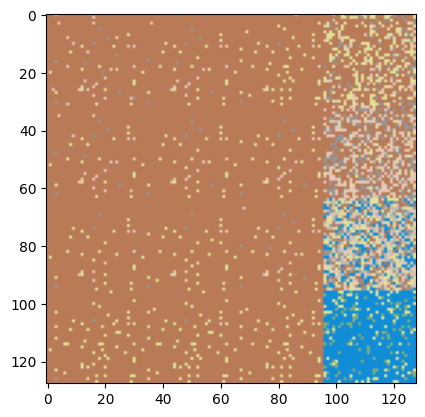

In [7]:
for example in test.take(3):
    # Get the true and predicted masks
    y_true = example[1]['conv2d_18']
    x = example[0]['input_1']

    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(fcn32_pred, axis=-1)

    for k in range(3):
        image_pred = np.zeros((128, 128, 3), dtype=np.uint8)
        for i in range(128):
            for j in range(128):
                image_pred[i, j, 0] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][0]
                image_pred[i, j, 1] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][1]
                image_pred[i, j, 2] = CLASS_TO_COLOR[y_pred[k, i, j].numpy()][2]

        plt.imshow(image_pred)
        plt.savefig(f'../img/fcn32_{k}.png')